In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

/Users/jvsingh/anaconda3/envs/rlproject/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [4]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [5]:
def backtest_strat(df, return_col_name):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret[return_col_name].values, index=strategy_ret.index)
    return ts

In [6]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        fname = 'results/account_value_trade_{}_{}.csv'.format(model_name,i)
        print(f"Reading {fname}")
        temp = pd.read_csv(fname)
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## S&P500

In [7]:
sp500 = pd.read_csv("data/wd_te.csv", parse_dates =['Date'])
sp500["Date"] = [d.date() for d in sp500.Date]
sp500 = sp500.loc[sp500.tic == "^GSPC",["Date","close","returns_close"]].reset_index(drop=True)
sp500.head()

,Date,close,returns_close
0,2005-12-01,1264.670044,0.012157
1,2005-12-02,1265.079956,0.000324
2,2005-12-05,1262.089966,-0.002363
3,2005-12-06,1263.699951,0.001276
4,2005-12-07,1257.369995,-0.005009


## Ensemble Strategy

In [8]:
ensemble_df = pd.read_csv('results/2021.12.11.215147_trading_value_returns_df_90_60.csv', parse_dates =['Date'])
ensemble_df["Date"] = [d.date() for d in ensemble_df.Date]

In [9]:
ensemble_df.head()

,Date,account_value,daily_return,tc_cost
0,2006-04-10,1000000.000000,NaN,NaN
1,2006-04-11,994607.722781,-0.005392,0.000060
2,2006-04-12,995602.027166,0.001000,0.000115
3,2006-04-13,993089.621811,-0.002524,0.000088
4,2006-04-17,993514.057074,0.000427,0.000137


In [10]:
both_df = pd.DataFrame({"Date": sorted(list(set(ensemble_df.Date).union(sp500.Date)))})\
    .merge(ensemble_df[["Date","daily_return"]].rename(columns={"daily_return":"ensemble_daily_return"}), 
           how='left', 
           left_on=["Date"], 
           right_on=["Date"])\
    .merge(sp500[["Date", "returns_close"]].rename(columns={"returns_close":"sp_daily_return"}),
           how='left', 
           left_on=["Date"], 
           right_on=["Date"]).dropna()
both_df

,Date,ensemble_daily_return,sp_daily_return
89,2006-04-11,-0.005392,-0.007751
90,2006-04-12,0.001000,0.001205
91,2006-04-13,-0.002524,0.000776
92,2006-04-17,0.000427,-0.002940
93,2006-04-18,0.015367,0.017077
...,...,...,...
4023,2021-11-24,0.001213,0.002294
4024,2021-11-26,-0.021521,-0.022725
4025,2021-11-29,0.012674,0.013200
4026,2021-11-30,0.001770,-0.018961


In [11]:
sp_strat = backtest_strat(both_df[["Date","sp_daily_return"]], "sp_daily_return")

sp_strat

Date
2006-04-11 00:00:00+00:00   -0.007751
2006-04-12 00:00:00+00:00    0.001205
2006-04-13 00:00:00+00:00    0.000776
2006-04-17 00:00:00+00:00   -0.002940
2006-04-18 00:00:00+00:00    0.017077
                               ...   
2021-11-24 00:00:00+00:00    0.002294
2021-11-26 00:00:00+00:00   -0.022725
2021-11-29 00:00:00+00:00    0.013200
2021-11-30 00:00:00+00:00   -0.018961
2021-12-01 00:00:00+00:00   -0.011815
Length: 3939, dtype: float64

In [12]:
ensemble_strat = backtest_strat(both_df[["Date","ensemble_daily_return"]],"ensemble_daily_return")


In [13]:
ensemble_strat

Date
2006-04-11 00:00:00+00:00   -0.005392
2006-04-12 00:00:00+00:00    0.001000
2006-04-13 00:00:00+00:00   -0.002524
2006-04-17 00:00:00+00:00    0.000427
2006-04-18 00:00:00+00:00    0.015367
                               ...   
2021-11-24 00:00:00+00:00    0.001213
2021-11-26 00:00:00+00:00   -0.021521
2021-11-29 00:00:00+00:00    0.012674
2021-11-30 00:00:00+00:00    0.001770
2021-12-01 00:00:00+00:00   -0.006984
Length: 3939, dtype: float64

In [14]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2006-04-11
End date,2021-12-01
Total months,187
,Backtest
Annual return,6.4%
Cumulative returns,164.8%
Annual volatility,10.7%
Sharpe ratio,0.64
Calmar ratio,0.20
Stability,0.93
Max drawdown,-31.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.60,2008-05-20,2009-03-09,2010-09-28,616
1,24.17,2020-02-19,2020-03-23,NaT,NaN
2,13.94,2018-01-26,2018-12-24,2019-06-07,356
3,8.91,2015-04-24,2015-08-25,2016-03-11,231
4,8.54,2011-07-22,2011-08-22,2011-10-27,70


Stress Events,mean,min,max
Lehman,-0.18%,-4.41%,1.41%
US downgrade/European Debt Crisis,0.04%,-2.25%,2.29%
Fukushima,0.07%,-0.85%,0.83%
EZB IR Event,0.08%,-0.35%,1.15%
Aug07,0.07%,-1.88%,1.29%
Mar08,0.09%,-1.62%,2.30%
Sept08,-0.22%,-4.41%,1.41%
2009Q1,-0.35%,-3.97%,2.64%
2009Q2,0.17%,-3.68%,3.91%
Flash Crash,0.02%,-1.23%,2.11%


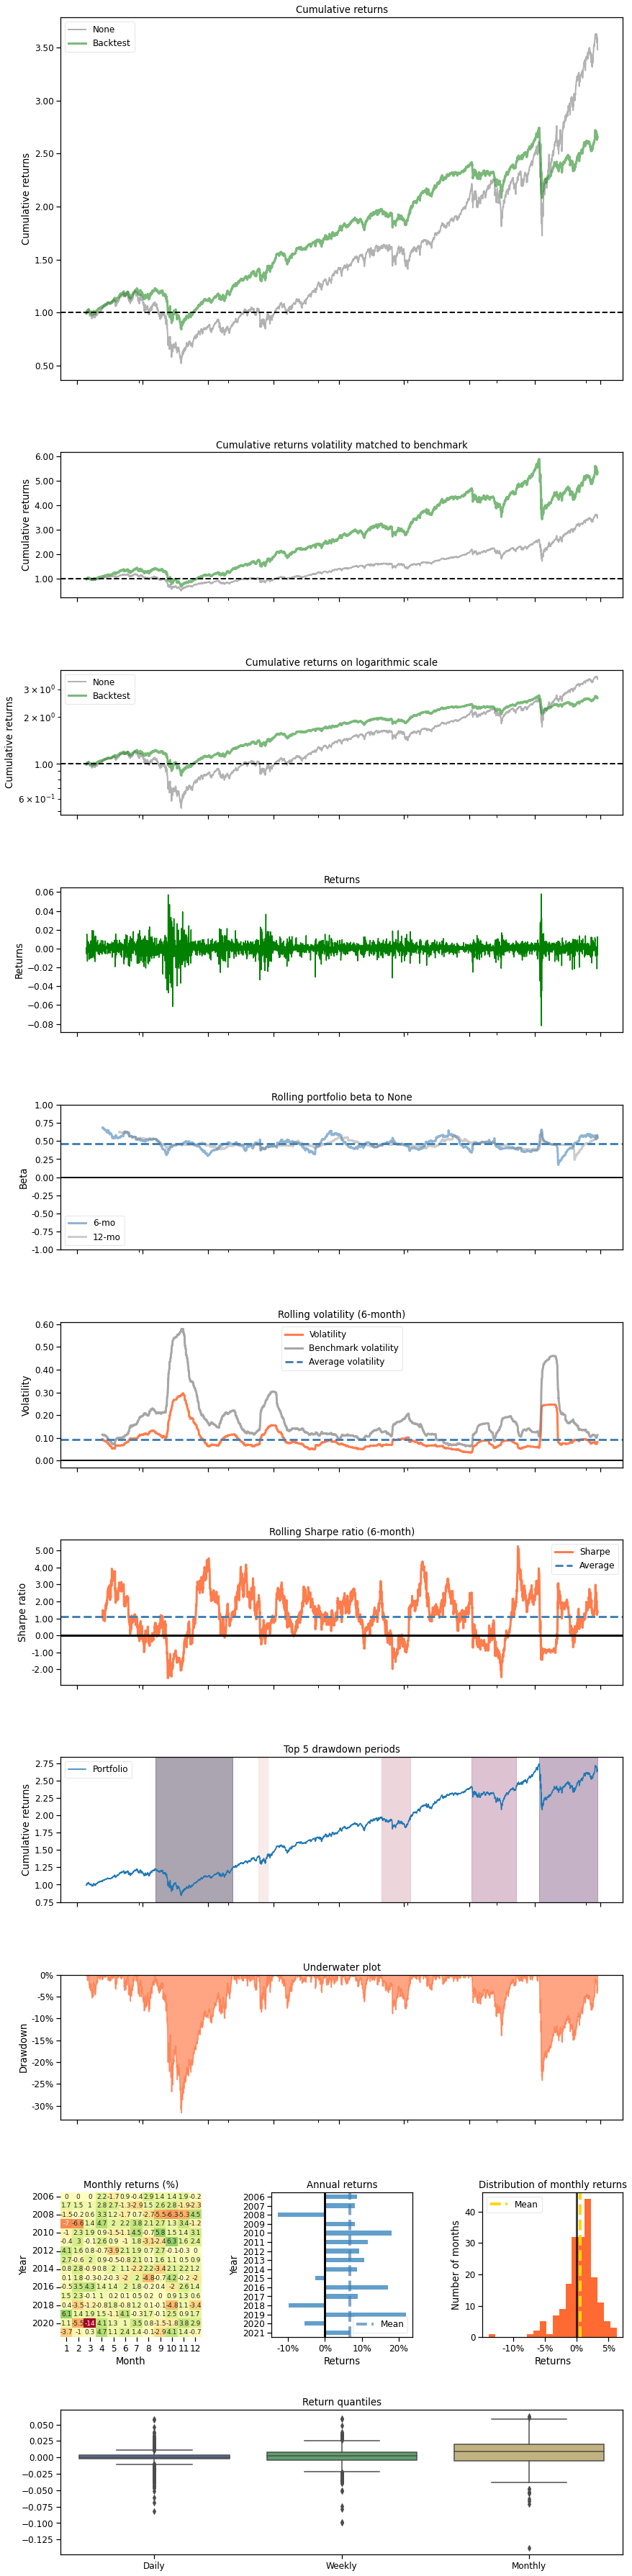

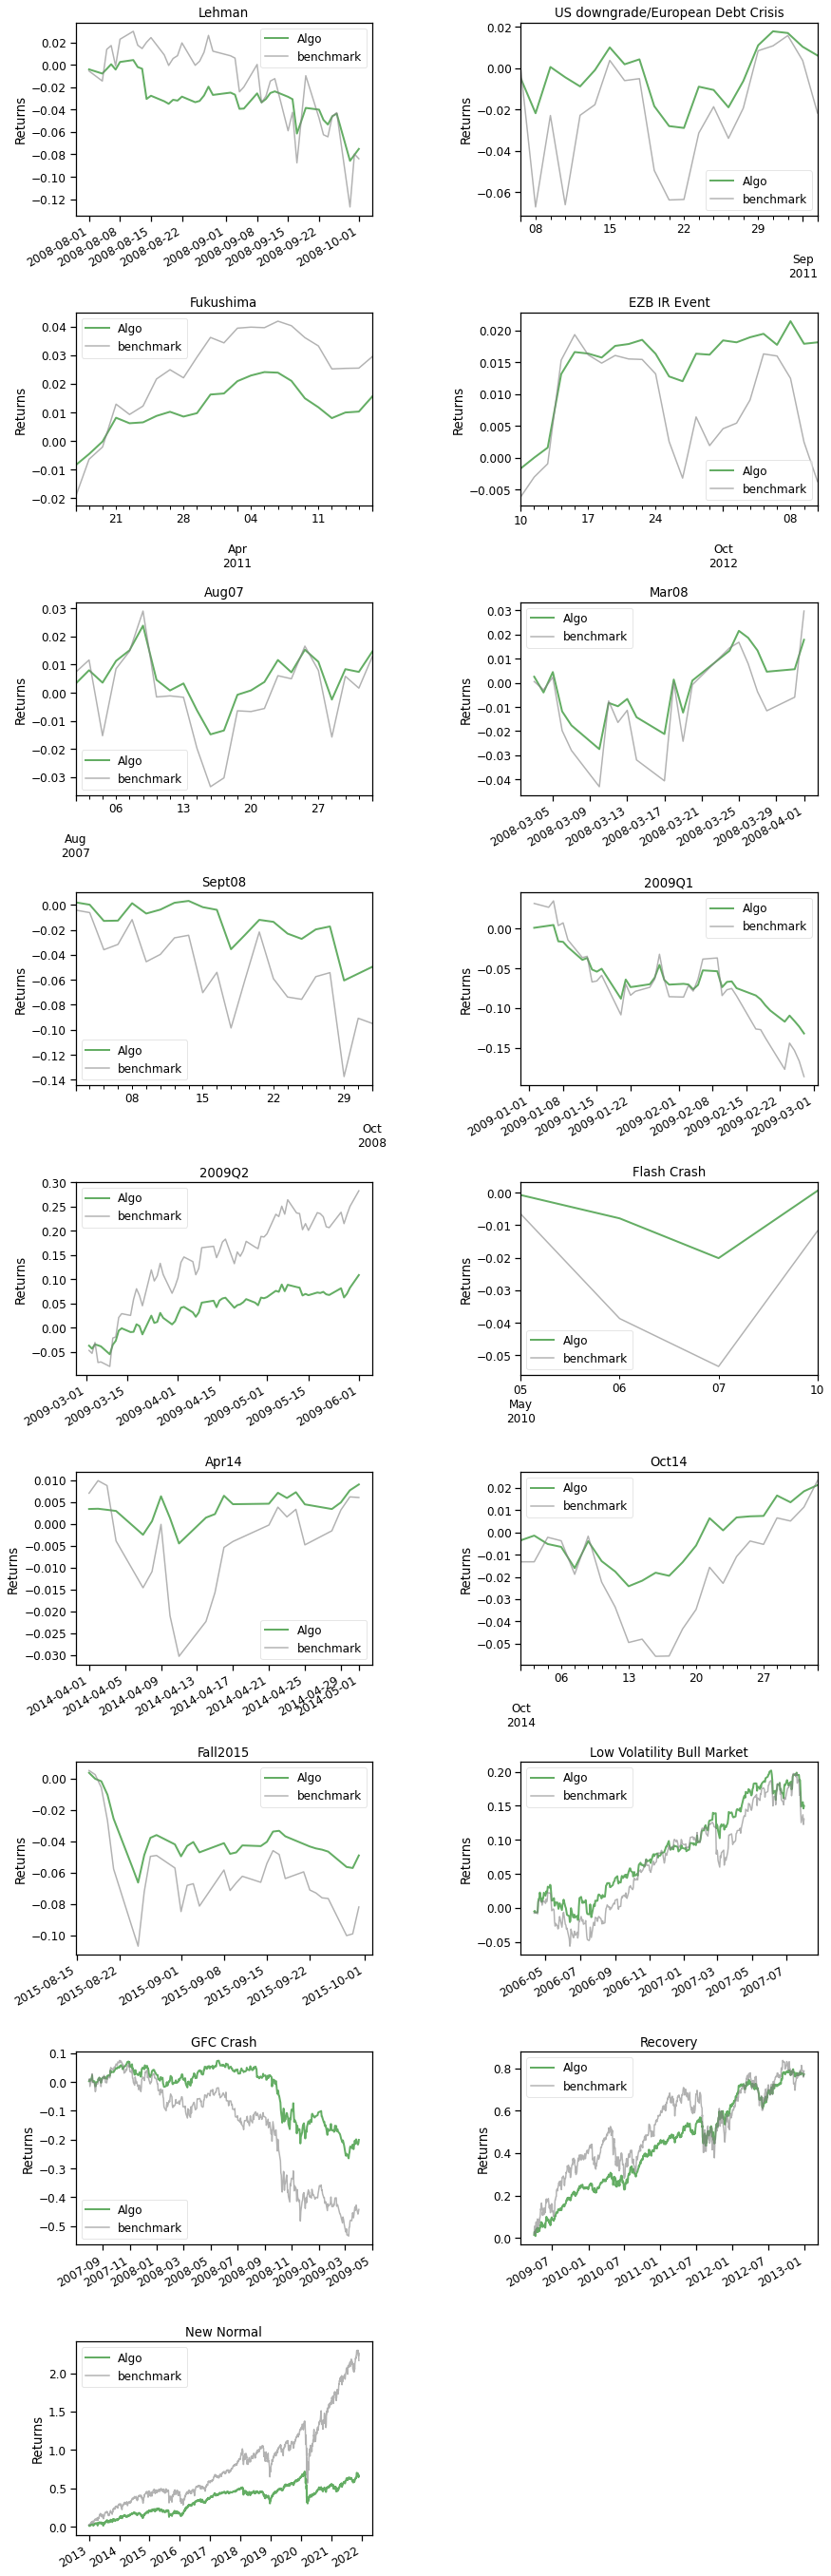

In [15]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=sp_strat, set_context=False)